# Import Libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import math
import torch
# from torch import vmap
from functorch import vmap, grad
from models import FNN2d
from train_utils import Adam
# from train_utils.datasets import BurgersLoader
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.WaveEq import WaveEq1D
import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np



from tqdm import tqdm
from train_utils.utils import save_checkpoint
from train_utils.losses import LpLoss

from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None


# Load/Update Config Functions:

In [2]:
def update_config(config, file):
    with open(file, 'w') as f:
        config_updated = yaml.dump(config, f)
        
def load_config(file):
    with open(file, 'r') as f:
        config = yaml.load(f, yaml.FullLoader)
    return config

# Define Data Loader:

In [3]:
class DataLoader(object):
    def __init__(self, x_data, y_data, nx=128, nt=100, sub=1, sub_t=1, new=True):
#         dataloader = MatReader(datapath)
        self.sub = sub
        self.sub_t = sub_t
        s = nx
        # if nx is odd
        if (s % 2) == 1:
            s = s - 1
        self.s = s // sub

        self.T = nt // sub_t
        self.new = new
        if new:
            self.T += 1
        self.x_data = x_data[:, 0:s:sub]
        self.y_data = y_data[:, 0:self.T:sub_t, 0:s:sub]

    def make_loader(self, n_sample, batch_size, start=0, train=True):
        Xs = self.x_data[start:start + n_sample]
        ys = self.y_data[start:start + n_sample]

        if self.new:
            gridx = torch.tensor(np.linspace(0, 1, self.s + 1)[:-1], dtype=torch.float)
            gridt = torch.tensor(np.linspace(0, 1, self.T), dtype=torch.float)
        else:
            gridx = torch.tensor(np.linspace(0, 1, self.s), dtype=torch.float)
            gridt = torch.tensor(np.linspace(0, 1, self.T + 1)[1:], dtype=torch.float)
        gridx = gridx.reshape(1, 1, self.s)
        gridt = gridt.reshape(1, self.T, 1)

        Xs = Xs.reshape(n_sample, 1, self.s).repeat([1, self.T, 1])
        Xs = torch.stack([Xs, gridx.repeat([n_sample, self.T, 1]), gridt.repeat([n_sample, 1, self.s])], dim=3)
        dataset = torch.utils.data.TensorDataset(Xs, ys)
        if train:
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        else:
            loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
        return loader

# Define Loss Functions

## Automatic Differentiation

In [4]:
def Autograd_Wave(u, grid, c=1.0):
    from torch.autograd import grad
    gridt, gridx = grid

    ut = grad(u.sum(), gridt, create_graph=True)[0]
    utt = grad(ut.sum(), gridt, create_graph=True)[0]
    ux = grad(u.sum(), gridx, create_graph=True)[0]
    uxx = grad(ux.sum(), gridx, create_graph=True)[0]
    Du = utt - c**2*uxx
    return Du, uxx, utt


def AD_loss_Wave(u, u0, grid, index_ic=None, p=None, q=None, c=1.0):
    batchsize = u.size(0)
    # lploss = LpLoss(size_average=True)

    Du, uxx, utt = Autograd_Wave(u, grid, c=c)

    if index_ic is None:
        # u in on a uniform grid
        nt = u.size(1)
        nx = u.size(2)
        u = u.reshape(batchsize, nt, nx)

        index_t = torch.zeros(nx,).long()
        index_x = torch.tensor(range(nx)).long()
        boundary_u = u[:, index_t, index_x]

        # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
        # loss_bc1 = F.mse_loss(ux[:, :, 0], ux[:, :, -1])
    else:
        # u is randomly sampled, 0:p are BC, p:2p are ic, 2p:2p+q are interior
        boundary_u = u[:, :p]
        batch_index = torch.tensor(range(batchsize)).reshape(batchsize, 1).repeat(1, p)
        u0 = u0[batch_index, index_ic]

        # loss_bc0 = F.mse_loss(u[:, p:p+p//2], u[:, p+p//2:2*p])
        # loss_bc1 = F.mse_loss(ux[:, p:p+p//2], ux[:, p+p//2:2*p])

    loss_ic = F.mse_loss(boundary_u, u0)
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)
    return loss_ic, loss_f

## Spectral Derivatives

In [5]:
def FDM_Wave(u, D=1, c=1.0):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    dt = D / (nt-1)
    dx = D / (nx)

    u_h = torch.fft.fft(u, dim=2)
    # Wavenumbers in y-direction
    k_max = nx//2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=u.device),
                     torch.arange(start=-k_max, end=0, step=1, device=u.device)), 0).reshape(1,1,nx)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    ux = torch.fft.irfft(ux_h[:, :, :k_max+1], dim=2, n=nx)
    uxx = torch.fft.irfft(uxx_h[:, :, :k_max+1], dim=2, n=nx)
    ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)
    utt = (u[:, 2:, :] - 2.0*u[:, 1:-1, :] + u[:, :-2, :]) / (dt**2)
    Du = utt - c**2 * uxx[:,1:-1,:]
    return Du


def PINO_loss_wave(u, u0, c=1.0):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    # lploss = LpLoss(size_average=True)

    index_t = torch.zeros(nx,).long()
    index_x = torch.tensor(range(nx)).long()
    boundary_u = u[:, index_t, index_x]
    loss_u = F.mse_loss(boundary_u, u0)

    Du = FDM_Wave(u, c=c)[:, :, :]
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_u, loss_f

# Define Training Function

In [6]:
def train_wave(model,
               train_loader,
               optimizer, 
               scheduler,
               config,
               rank=0, 
               log=False,
               project='PINO-2d-default',
               group='default',
               tags=['default'],
               use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    c = config['data']['c']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_ic = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
#             display(x.shape, y.shape)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_ic, loss_f = PINO_loss_wave(out, x[:, 0, :, 0], c=c)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
            train_ic += loss_ic.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

# Evaluation Function

In [7]:
def eval_wave(model,
              dataloader,
              config,
              device,
              use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    c = config['data']['c']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []

    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        out = model(x).reshape(y.shape)
        data_loss = myloss(out, y)

        loss_u, f_loss = PINO_loss_wave(out, x[:, 0, :, 0], c=c)
        test_err.append(data_loss.item())
        f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



# Checkpoint Loading

In [8]:
def load_checkpoint(model, ckpt_path, optimizer=None):
    try:
        ckpt = torch.load(ckpt_path)
        model.load_state_dict(ckpt['model'])
        print('Weights loaded from %s' % ckpt_path)
        if optimizer is not None:
            try:
                optimizer.load_state_dict(ckpt['optim'])
                print('Optimizer loaded from %s' % ckpt_path)
            except: traceback.print_exc()
            
    except:
        traceback.print_exc()

# Load Config File

In [9]:
config_file = 'configs/custom/wave-0000.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Wave-0000',
  'total_num': 1000,
  'n_train': 900,
  'n_test': 100,
  'nx': 4096,
  'nt': 100,
  'sub': 32,
  'sub_t': 1,
  'c': 1.0},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 500,
  'milestones': [150, 300, 450],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 10.0,
  'save_dir': 'Wave',
  'save_name': 'Wave-eqn.pt',
  'ckpt': 'checkpoints/Wave/Wave-eqn.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Wave', 'group': 'Wave-0000'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Wave/Wave-eqn.pt'}}

# Parameters

In [10]:
# dim = 1
# N = 4096
# Nx = 4096
# l = 0.1
# Nk = None
# Nsamples = 1000
# # jitter = 1e-12
# dt = 1.0e-4
# save_int = int(1e-2/dt)

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# grf = GaussianRF(dim, N, length=1.0, alpha=2.5, tau=5.0, device=device)
# U0 = grf.sample(Nsamples)

In [11]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
c = config['data']['c']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.1
L = 1.0
sigma = 0.2 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
sub_x

32

In [13]:
4096//sub_x

128

# Generate Random Fields

In [14]:
# grf = GaussianRF(dim, N, length=1.0, alpha=2.5, tau=5.0, device=device)
# U0 = grf.sample(Nsamples)

In [15]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)

In [16]:
U0.shape

torch.Size([1000, 4096])

In [17]:
U0.shape

torch.Size([1000, 4096])

In [18]:
# if dim == 1:
#     U = np.array([GRF.plot_sample(X, sample, dim, shape) for sample in samples])
# if dim == 2:
#     U = np.array([plot_surf(X, sample, shape) for sample in samples])

In [19]:
wave_eq = WaveEq1D(Nx=N, c=c, dt=dt, device=device)
U = vmap(wave_eq.wave_driver, in_dims=(0, None))(U0, save_int)

In [20]:
a = U0.cpu().float()
u = U.cpu().float()

display(u.shape,a.shape)

torch.Size([1000, 102, 4096])

torch.Size([1000, 4096])

In [21]:
# config_file_train = 'configs/custom/wave-train-0000.yaml'
# config_file_test = 'configs/custom/wave-test-0000.yaml'
# with open(config_file_train, 'r') as stream:
#     config_train = yaml.load(stream, yaml.FullLoader)
# with open(config_file_test, 'r') as stream:
#     config_test = yaml.load(stream, yaml.FullLoader)

In [22]:
dataset = DataLoader(a, u, config['data']['nx'], config['data']['nt'], config['data']['sub'], config['data']['sub_t'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [23]:
log = False
model = FNN2d(modes1=config['model']['modes1'],
                  modes2=config['model']['modes2'],
                  fc_dim=config['model']['fc_dim'],
                  layers=config['model']['layers'],
                  activation=config['model']['activation']).to(device)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

# Load from checkpoint

In [24]:
load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)

Weights loaded from checkpoints/Wave/Wave-eqn.pt


# Train the Model

In [125]:

train_wave(model,
           train_loader,
           optimizer,
           scheduler,
           config,
           rank=0,
           log=log,
           project=config['log']['project'],
           group=config['log']['group'])

Epoch 0, train loss: 11.09598 train f error: 0.19722; data l2 error: 1.08572; train ic error: 0.37393:   0%|          | 1/500 [00:01<09:34,  1.15s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_0.pt


Epoch 100, train loss: 0.15661 train f error: 0.05580; data l2 error: 0.01008; train ic error: 0.00003:  20%|██        | 101/500 [01:52<07:24,  1.11s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_100.pt


Epoch 200, train loss: 0.12669 train f error: 0.06106; data l2 error: 0.00656; train ic error: 0.00002:  40%|████      | 201/500 [03:43<05:35,  1.12s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_200.pt


Epoch 300, train loss: 0.09267 train f error: 0.06581; data l2 error: 0.00269; train ic error: 0.00001:  60%|██████    | 301/500 [05:35<03:42,  1.12s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_300.pt


Epoch 400, train loss: 0.09134 train f error: 0.06733; data l2 error: 0.00240; train ic error: 0.00000:  80%|████████  | 401/500 [07:26<01:50,  1.12s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn_400.pt


Epoch 499, train loss: 0.08624 train f error: 0.07007; data l2 error: 0.00162; train ic error: 0.00000: 100%|██████████| 500/500 [09:17<00:00,  1.12s/it]

Checkpoint is saved at checkpoints/Wave/Wave-eqn.pt
Done!


# Evaluate on Test Data

In [25]:
eval_wave(model, test_loader, config, device)

100%|██████████| 100/100 [00:00<00:00, 236.71it/s]

==Averaged relative L2 error mean: 0.0012154258752707391, std error: 2.8122548682792986e-05==
==Averaged equation error mean: 0.0747406174428761, std error: 0.003449729510826108==


In [107]:
eval_wave(model, test_loader, config, device)

100%|██████████| 100/100 [00:00<00:00, 284.21it/s]

==Averaged relative L2 error mean: 0.03709864497184753, std error: 0.0009186125951561321==
==Averaged equation error mean: 0.012226411206647754, std error: 0.00044778704791337395==


In [26]:
Nx = config['data']['nx'] // config['data']['sub']
Nt = config['data']['nt'] // config['data']['sub_t'] + 1
Ntest = config['data']['n_test']
model.eval()
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [27]:
key = 1
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

In [28]:
plt.rcParams.update({'font.size': 11})

<IPython.core.display.Javascript object>


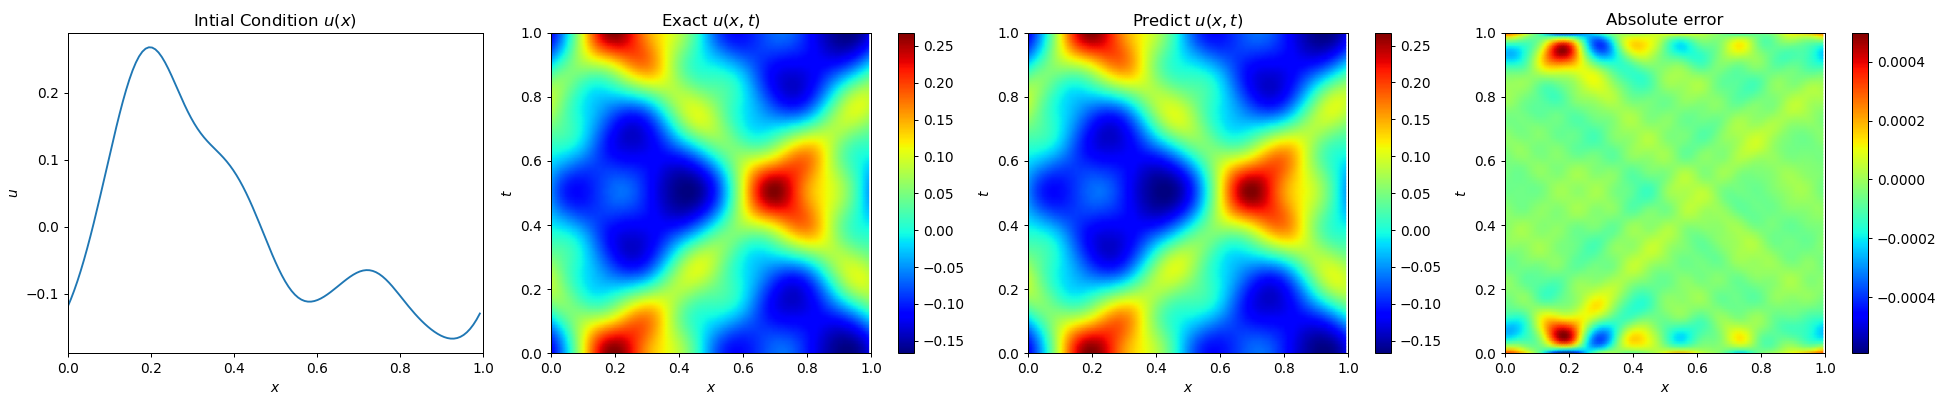

(0.0, 1.0, 0.0, 1.0)

In [29]:
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $u(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $u(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

# plt.show()

<IPython.core.display.Javascript object>


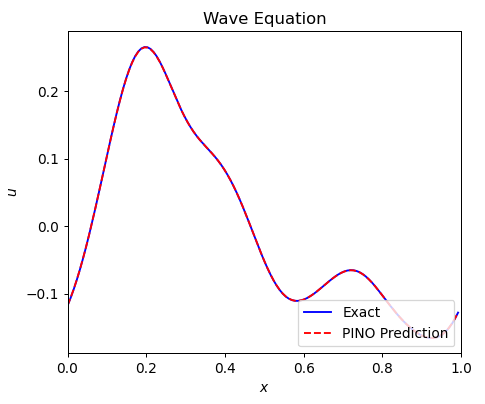

In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Wave Equation')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()


# Save and Load Data

In [2]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [3]:
data_dir = 'data/Wave1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [33]:
save_data(data_path, test_x, test_y, preds_y)

In [4]:
test_x, test_y, preds_y = load_data(data_path)

In [7]:
def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))
    plt.subplot(1,4,1)

    plt.plot(x, u0)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.tight_layout()

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Exact $u(x,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Predict $u(x,t)$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


In [ ]:
%matplotlib inline
figures_dir = 'Wave1D/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
# for key in range(10):
    save_path = os.path.join(figures_dir, f'Wave1D_{key}')
#     plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=None)
    plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)



0.003038763999938965

<IPython.core.display.Javascript object>


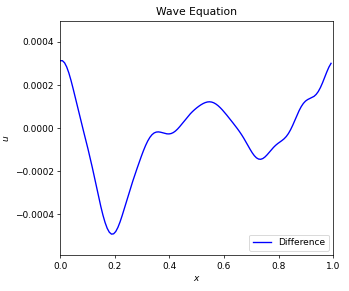

In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()


fig.show()
fig.canvas.draw()
diff = pred - true
ax.plot(x, pred[0] - true[0], 'b-', label='Difference')
# ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = [diff.min(), diff.max()]
xlim = [0, 1]
plt.xlim(xlim)
plt.ylim(ylim)
plt.tight_layout()



for i in range(Nt):
    ax.clear()
#     ax.plot(x, true[i], 'b-', label='Exact')
#     ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    ax.plot(x, diff[i], 'b-', label='Difference')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Wave Equation')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()
